In [2]:
# Step 1: Imports
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import joblib

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Step 2: Paths
data_dir = r"C:\Users\manog\Downloads\biometric_attendance_system\student_database\faces"
model_save_path = r"C:\Users\manog\Downloads\biometric_attendance_system\cnn_models\face_classifier.pkl"

# Step 3: Initialize MobileNetV2 for embeddings
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Step 4: Load images and labels
X = []
y = []

print("[INFO] Loading dataset...")
for student_id in os.listdir(data_dir):
    student_folder = os.path.join(data_dir, student_id)
    if not os.path.isdir(student_folder):
        continue
    for image_name in os.listdir(student_folder):
        image_path = os.path.join(student_folder, image_name)
        image = cv2.imread(image_path)
        if image is None:
            continue
        image = cv2.resize(image, (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        X.append(image)
        y.append(student_id)

X = np.array(X, dtype="float32")
y = np.array(y)

print(f"[INFO] Loaded {len(X)} images of {len(np.unique(y))} students.")

# Step 5: Generate embeddings
print("[INFO] Generating embeddings...")
embeddings = model.predict(X, batch_size=32, verbose=1)

# Step 6: Encode labels
print("[INFO] Encoding labels...")
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Step 7: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(embeddings, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Step 8: Train SVM classifier
print("[INFO] Training SVM classifier...")
clf = SVC(kernel="linear", probability=True)
clf.fit(X_train, y_train)

# Step 9: Evaluate
y_pred = clf.predict(X_test)
print("[INFO] Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Step 10: Save model and label encoder
print("[INFO] Saving model and label encoder...")
joblib.dump((clf, le), model_save_path)

print("[DONE] Model saved to:", model_save_path)

[INFO] Loading dataset...
[INFO] Loaded 2781 images of 139 students.
[INFO] Generating embeddings...
87/87 ━━━━━━━━━━━━━━━━━━━━ 40s 429ms/step
[INFO] Encoding labels...
[INFO] Training SVM classifier...
[INFO] Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         4
         100       1.00      1.00      1.00         4
         101       1.00      1.00      1.00         4
         103       1.00      1.00      1.00         4
         104       1.00      1.00      1.00         4
         105       1.00      1.00      1.00         4
         107       1.00      1.00      1.00         4
         108       1.00      1.00      1.00         4
         109       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         5
         110       1.00      1.00      1.00         4
         113       1.00      1.00      1.00         4
         1

In [3]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[4 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 4]]


In [7]:
y_true = np.concatenate([np.ones_like(genuine_scores), np.zeros_like(impostor_scores)])
y_score = np.concatenate([genuine_scores, impostor_scores])


In [8]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)


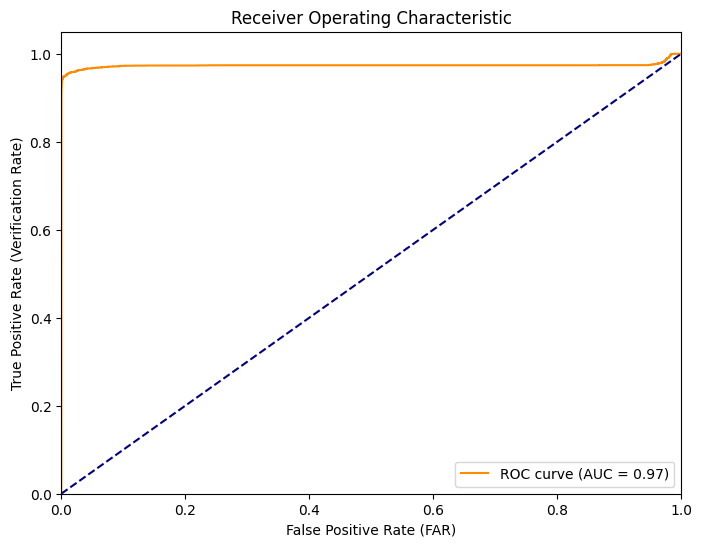

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FAR)')
plt.ylabel('True Positive Rate (Verification Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
